In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/config.json
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/merges.txt
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/LICENSE
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/README.md
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/tokenizer.json
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/vocab.json
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/tokenizer_config.json
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/model.safetensors
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/configuration.json
/kaggle/input/qwen2/transformers/qwen2-0.5b-instruct/1/generation_config.json


In [2]:
!pip install transformers datasets evaluate torch

In [3]:
import os
import pandas as pd
import torch
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# --- 1. Load Model and Tokenizer ---
print(f"Loading model: {model_path}")
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)
print("Model and tokenizer loaded successfully.")

# --- 2. Sort All Layers by Parameter Proportion ---
print("\n--- Analyzing Model Layers ---")
layer_params = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Embedding):
        num_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        if num_params > 0:
            layer_params.append((name, num_params))

sorted_layers = sorted(layer_params, key=lambda x: x[1], reverse=True)
df_layers = pd.DataFrame(sorted_layers, columns=['Layer Name', 'Number of Parameters'])
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
df_layers['Percentage of Total'] = (df_layers['Number of Parameters'] / total_params) * 100
print("All Layers Sorted by Parameter Count:")
print(df_layers.to_string())

# --- 3. Select the Layer with the Highest Percentage of Parameters ---
top_layer_info = df_layers.iloc[0]
top_layer_name = top_layer_info['Layer Name']
print(f"\nSelected for pruning (Largest Layer): '{top_layer_name}' with {top_layer_info['Number of Parameters']:,} parameters ({top_layer_info['Percentage of Total']:.2f}% of total)")

# --- 4. Pruning and Evaluation Workflow ---

def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    print("Evaluating perplexity with sliding window...")
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")
    max_length = 2048
    stride = 512
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        if input_ids.size(1) < 2:
            continue
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

# --- Main Loop for Pruning and Evaluation ---
sparsity_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 0.95]
results_data = []
target_module = dict(model.named_modules())[top_layer_name]

# *** FIX: Move the state_dict to CPU RAM before cloning to prevent OOM Error ***
print("\nCreating a model backup on the CPU...")
original_state_dict = {k: v.to('cpu').clone() for k, v in model.state_dict().items()}
print("Backup created successfully.")

torch.cuda.empty_cache()

print("\n--- Starting Iterative Pruning and Evaluation ---")
for sparsity in sparsity_levels:
    # load_state_dict will automatically move the CPU tensors back to the correct GPU device
    model.load_state_dict(original_state_dict)
    print(f"\n--- Processing Sparsity: {sparsity*100:.0f}% ---")
    if sparsity > 0.0:
        print(f"Applying {sparsity*100:.0f}% pruning to '{top_layer_name}'...")
        prune.l1_unstructured(target_module, name="weight", amount=sparsity)
        prune.remove(target_module, 'weight')
    perplexity = evaluate_perplexity(model, tokenizer)
    results_data.append({'Sparsity (%)': int(sparsity * 100), 'Perplexity': perplexity})
    print(f"Result: Sparsity = {sparsity*100:.0f}%, Perplexity = {perplexity:.4f}")
    torch.cuda.empty_cache()

# --- 5. Identify the Maximum Pruning Ratio ---
print("\n--- Pruning Experiment Complete ---")
df_results = pd.DataFrame(results_data)
df_results.set_index('Sparsity (%)', inplace=True)
print("Final Results:")
print(df_results)
baseline_perplexity = df_results.loc[0]['Perplexity']
print(f"\nAnalysis:")
print(f"Baseline perplexity (0% pruning) is: {baseline_perplexity:.4f}")
print("Lower perplexity is better. A sharp increase indicates significant performance degradation.")
acceptable_threshold = baseline_perplexity * 2
acceptable_pruning = df_results[df_results['Perplexity'] <= acceptable_threshold]
if not acceptable_pruning.empty:
    max_pruning_ratio = acceptable_pruning.index.max()
    print(f"The maximum pruning ratio that keeps perplexity below {acceptable_threshold:.2f} (2x baseline) is: {max_pruning_ratio}%")
else:
    print("Even 25% pruning caused a significant drop in performance beyond the 2x baseline threshold.")

Loading model: Qwen/Qwen2-0.5B-Instruct


2025-06-21 10:18:54.654664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750501134.675217     127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750501134.681076     127 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model and tokenizer loaded successfully.

--- Analyzing Model Layers ---
All Layers Sorted by Parameter Count:
                           Layer Name  Number of Parameters  Percentage of Total
0                  model.embed_tokens             136134656            27.555795
1                             lm_head             136134656            27.555795
2        model.layers.0.mlp.gate_proj               4358144             0.882157
3          model.layers.0.mlp.up_proj               4358144             0.882157
4        model.layers.0.mlp.down_proj               4358144             0.882157
5        model.layers.1.mlp.gate_proj               4358144             0.882157
6          model.layers.1.mlp.up_proj               4358144             0.882157
7        model.layers.1.mlp.down_proj               4358144             0.882157
8        model.layers.2.mlp.gate_proj               4358144             0.882157
9          model.layers.2.mlp.up_proj               4358144             0.88215

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [01:25<00:00,  6.83it/s]


Result: Sparsity = 0%, Perplexity = 12.5985

--- Processing Sparsity: 25% ---
Applying 25% pruning to 'model.embed_tokens'...
Evaluating perplexity with sliding window...


Evaluating Chunks:  99%|█████████▉| 581/585 [01:28<00:00,  6.55it/s]


Result: Sparsity = 25%, Perplexity = 12.9024

--- Processing Sparsity: 50% ---
Applying 50% pruning to 'model.embed_tokens'...
Evaluating perplexity with sliding window...


Evaluating Chunks:  99%|█████████▉| 581/585 [01:28<00:00,  6.57it/s]


Result: Sparsity = 50%, Perplexity = 17.0475

--- Processing Sparsity: 75% ---
Applying 75% pruning to 'model.embed_tokens'...
Evaluating perplexity with sliding window...


Evaluating Chunks:  99%|█████████▉| 581/585 [01:28<00:00,  6.57it/s]


Result: Sparsity = 75%, Perplexity = 89.3184

--- Processing Sparsity: 90% ---
Applying 90% pruning to 'model.embed_tokens'...
Evaluating perplexity with sliding window...


Evaluating Chunks:  99%|█████████▉| 581/585 [01:28<00:00,  6.57it/s]


Result: Sparsity = 90%, Perplexity = 6319.6558

--- Processing Sparsity: 95% ---
Applying 95% pruning to 'model.embed_tokens'...
Evaluating perplexity with sliding window...


Evaluating Chunks:  99%|█████████▉| 581/585 [01:28<00:00,  6.58it/s]


Result: Sparsity = 95%, Perplexity = 38864.8047

--- Pruning Experiment Complete ---
Final Results:
                Perplexity
Sparsity (%)              
0                12.598527
25               12.902409
50               17.047497
75               89.318359
90             6319.655762
95            38864.804688

Analysis:
Baseline perplexity (0% pruning) is: 12.5985
Lower perplexity is better. A sharp increase indicates significant performance degradation.
The maximum pruning ratio that keeps perplexity below 25.20 (2x baseline) is: 50%


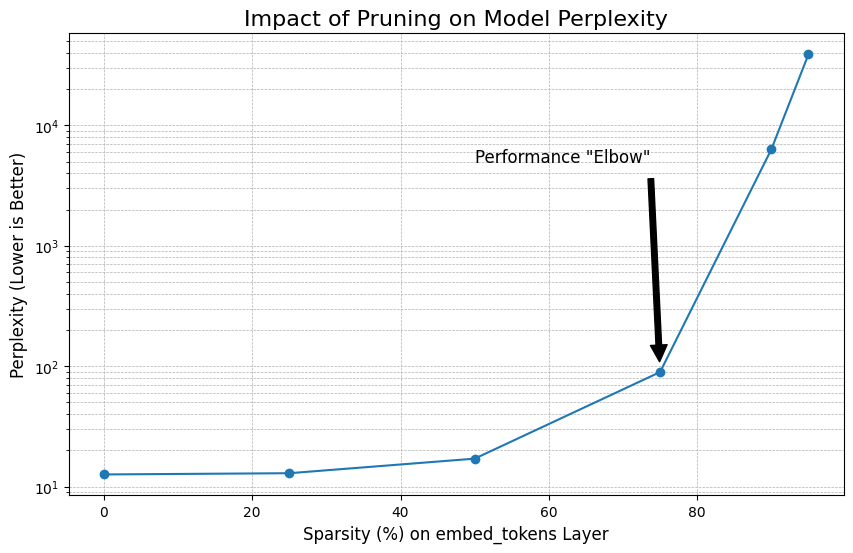

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Re-create the DataFrame from your results
data = {
    'Sparsity (%)': [0, 25, 50, 75, 90, 95],
    'Perplexity': [12.5985, 12.9024, 17.0475, 89.3184, 6319.6558, 38864.8047]
}
df_results = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_results['Sparsity (%)'], df_results['Perplexity'], marker='o', linestyle='-')

# Add titles and labels for clarity
plt.title('Impact of Pruning on Model Perplexity', fontsize=16)
plt.xlabel('Sparsity (%) on embed_tokens Layer', fontsize=12)
plt.ylabel('Perplexity (Lower is Better)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate the "elbow" point
plt.annotate('Performance "Elbow"',
             xy=(75, 89.32),
             xytext=(50, 5000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

# Use a logarithmic scale for the y-axis to better visualize the huge jump
plt.yscale('log')
plt.show()

In [5]:
import os
import pandas as pd
import torch
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
# The model path is from the provided notebook.
# Ensure you have access to this model, e.g., via Hugging Face Hub.
model_path = "Qwen/Qwen2-0.5B-Instruct"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# --- 1. Load Model and Tokenizer ---
print(f"Loading model: {model_path}")
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load the model onto the GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)
print("Model and tokenizer loaded successfully.")

# --- 2. Perplexity Evaluation Function (from the original notebook) ---
def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    """
    Evaluates the perplexity of a model on a given dataset using a sliding window approach.
    """
    print("Evaluating perplexity with sliding window...")
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")

    max_length = 2048  # Max length for each chunk
    stride = 512     # Sliding window stride
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        if input_ids.size(1) < 2:
            continue

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

# --- 3. Pruning and Evaluation Workflow for ALL Layers ---

# Sparsity levels to test, as requested
sparsity_levels = [0.0, 0.25, 0.50]
results_data = []

# Create a backup of the original model's state on CPU to prevent GPU OOM errors
print("\nCreating a model backup on the CPU...")
original_state_dict = {k: v.to('cpu').clone() for k, v in model.state_dict().items()}
print("Backup created successfully.")

# Identify all prunable layers (Linear and Embedding)
prunable_modules = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Embedding):
        prunable_modules.append(module)

print(f"\nIdentified {len(prunable_modules)} prunable layers to be pruned equally.")

# Clear cache before starting the main loop
torch.cuda.empty_cache()

print("\n--- Starting Iterative Pruning and Evaluation on ALL Prunable Layers ---")
for sparsity in sparsity_levels:
    # Reset the model to its original, unpruned state before applying a new sparsity level
    model.load_state_dict(original_state_dict)
    print(f"\n--- Processing Sparsity: {sparsity*100:.0f}% ---")

    if sparsity > 0.0:
        print(f"Applying {sparsity*100:.0f}% L1 unstructured pruning to all identified layers...")
        
        # Apply the pruning mask to each identified module
        for module in prunable_modules:
            prune.l1_unstructured(module, name="weight", amount=sparsity)
        
        # Make the pruning permanent by removing the re-parameterization hooks
        for module in prunable_modules:
            prune.remove(module, 'weight')

    # Evaluate the perplexity of the pruned model
    perplexity = evaluate_perplexity(model, tokenizer)
    results_data.append({'Sparsity (%)': int(sparsity * 100), 'Perplexity': perplexity})
    print(f"Result: Sparsity = {sparsity*100:.0f}%, Perplexity = {perplexity:.4f}")
    
    # Clean up GPU memory
    torch.cuda.empty_cache()

# --- 4. Display Final Results ---
print("\n--- Pruning Experiment Complete ---")
df_results = pd.DataFrame(results_data)
df_results.set_index('Sparsity (%)', inplace=True)
print("Final Results:")
print(df_results)

Loading model: Qwen/Qwen2-0.5B-Instruct
Model and tokenizer loaded successfully.

Creating a model backup on the CPU...
Backup created successfully.

Identified 170 prunable layers to be pruned equally.

--- Starting Iterative Pruning and Evaluation on ALL Prunable Layers ---

--- Processing Sparsity: 0% ---
Evaluating perplexity with sliding window...


Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [01:29<00:00,  6.51it/s]


Result: Sparsity = 0%, Perplexity = 12.5985

--- Processing Sparsity: 25% ---
Applying 25% L1 unstructured pruning to all identified layers...
Evaluating perplexity with sliding window...


Evaluating Chunks:  99%|█████████▉| 581/585 [01:28<00:00,  6.57it/s]


Result: Sparsity = 25%, Perplexity = 15.2146

--- Processing Sparsity: 50% ---
Applying 50% L1 unstructured pruning to all identified layers...
Evaluating perplexity with sliding window...


Evaluating Chunks:  99%|█████████▉| 581/585 [01:28<00:00,  6.58it/s]


Result: Sparsity = 50%, Perplexity = 184.5858

--- Pruning Experiment Complete ---
Final Results:
              Perplexity
Sparsity (%)            
0              12.598527
25             15.214593
50            184.585800


In [9]:
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# --- Constants and Configuration ---
model_path = "Qwen/Qwen2-0.5B-Instruct"
output_csv_filename = "statistical_analysis_of_layers.csv"

# --- 1. Load Model and Tokenizer ---
print(f"Loading model: {model_path}")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)
print("Model loaded successfully.")


# --- 2. Perform Statistical Analysis ---
print("\n--- Performing Statistical Analysis of Model Layers ---")

layer_stats = []
# Iterate through all named modules in the model
for name, module in model.named_modules():
    # We are interested in layers that have a 'weight' parameter
    if (isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Embedding)) and hasattr(module, 'weight'):
        # Use torch.no_grad() to ensure no gradients are computed during this analysis
        with torch.no_grad():
            weights = module.weight.data
            num_params = weights.numel()

            # Move weights to float32 for stable calculations, then get stats
            # .item() moves the scalar value from the GPU to the CPU
            mean_val = weights.to(torch.float32).mean().item()
            std_val = weights.to(torch.float32).std().item()
            min_val = weights.min().item()
            max_val = weights.max().item()

            layer_stats.append({
                'Layer Name': name,
                'Number of Parameters': num_params,
                'Mean': mean_val,
                'Std Dev': std_val,
                'Min': min_val,
                'Max': max_val
            })

# Create a DataFrame from the collected statistics
df_stats = pd.DataFrame(layer_stats)

# Sort the DataFrame by the number of parameters in descending order for better analysis
df_stats = df_stats.sort_values(by='Number of Parameters', ascending=False).reset_index(drop=True)


# --- 3. Save DataFrame to CSV File ---
# This line saves the DataFrame to a CSV file.
# The `index=False` argument prevents pandas from writing the DataFrame index as a column.
df_stats.to_csv(output_csv_filename, index=False)

print(f"\nStatistical analysis complete. The results have been saved to '{output_csv_filename}'.")

# (Optional) Print the table to the console as well
print("\nStatistical Analysis of Model Layer Weights:")
pd.set_option('display.max_rows', 15) # Adjust how many rows to print
print(df_stats)

Loading model: Qwen/Qwen2-0.5B-Instruct
Model loaded successfully.

--- Performing Statistical Analysis of Model Layers ---

Statistical analysis complete. The results have been saved to 'statistical_analysis_of_layers.csv'.

Statistical Analysis of Model Layer Weights:
                           Layer Name  Number of Parameters      Mean  \
0                  model.embed_tokens             136134656  0.000137   
1                             lm_head             136134656  0.000137   
2         model.layers.11.mlp.up_proj               4358144 -0.000002   
3       model.layers.11.mlp.gate_proj               4358144  0.000094   
4       model.layers.10.mlp.down_proj               4358144  0.000006   
..                                ...                   ...       ...   
165   model.layers.1.self_attn.v_proj                114688 -0.000029   
166   model.layers.2.self_attn.k_proj                114688  0.000007   
167   model.layers.2.self_attn.v_proj                114688  0.000002   

In [15]:
!pip install -U bitsandbytes

In [1]:
!pip install -U -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 24.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00:00:0100:01


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# --- Constants and Configuration ---
model_path = "Qwen/Qwen2-0.5B-Instruct"

# --- 1. Load Model and Tokenizer with 8-Bit Quantization ---
print("Loading model with 8-bit quantization...")

# Configuration for 8-bit quantization
quantization_config_8bit = BitsAndBytesConfig(load_in_8bit=True)

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the model with the specified quantization config
model_8bit = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=quantization_config_8bit,
    device_map="auto",
)

print("\n--- Model Loaded with 8-Bit Quantization ---")

# --- 2. Verify Model Layers ---
# You can inspect the model to see that the Linear layers have been replaced.
print("\nVerifying a layer in the 8-bit quantized model:")
print(model_8bit.model.layers[0].mlp.gate_proj)

# --- 3. Statistical Analysis of the 8-Bit Model ---
# You can run the same statistical analysis as before on the quantized model.
# Note that accessing the '.weight' attribute of a bnb quantized layer
# gives you the de-quantized weights for analysis.

import pandas as pd

print("\n--- Performing Statistical Analysis of 8-Bit Model Layers ---")

layer_stats_8bit = []
for name, module in model_8bit.named_modules():
    # Check for bitsandbytes quantized linear layers
    if isinstance(module, torch.nn.Module) and 'Linear' in str(type(module)):
         if hasattr(module, 'weight'):
            with torch.no_grad():
                weights = module.weight.data
                num_params = weights.numel()

                mean_val = weights.to(torch.float32).mean().item()
                std_val = weights.to(torch.float32).std().item()
                min_val = weights.min().item()
                max_val = weights.max().item()

                layer_stats_8bit.append({
                    'Layer Name': name,
                    'Data Type': weights.dtype,
                    'Number of Parameters': num_params,
                    'Mean': mean_val,
                    'Std Dev': std_val,
                    'Min': min_val,
                    'Max': max_val
                })

df_stats_8bit = pd.DataFrame(layer_stats_8bit)
df_stats_8bit.to_csv("statistical_analysis_8bit_model.csv", index=False)
print("\n8-bit model analysis saved to 'statistical_analysis_8bit_model.csv'")
print(df_stats_8bit.head())

Loading model with 8-bit quantization...


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

2025-06-21 10:44:04.984113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750502645.209175      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750502645.275127      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]


--- Model Loaded with 8-Bit Quantization ---

Verifying a layer in the 8-bit quantized model:
Linear8bitLt(in_features=896, out_features=4864, bias=False)

--- Performing Statistical Analysis of 8-Bit Model Layers ---

8-bit model analysis saved to 'statistical_analysis_8bit_model.csv'
                        Layer Name   Data Type  Number of Parameters  \
0  model.layers.0.self_attn.q_proj  torch.int8                802816   
1  model.layers.0.self_attn.k_proj  torch.int8                114688   
2  model.layers.0.self_attn.v_proj  torch.int8                114688   
3  model.layers.0.self_attn.o_proj  torch.int8                802816   
4     model.layers.0.mlp.gate_proj  torch.int8               4358144   

       Mean    Std Dev    Min    Max  
0 -0.028345  31.696020 -127.0  127.0  
1  0.043937  37.080254 -127.0  127.0  
2 -0.023141  33.155426 -127.0  127.0  
3 -0.015533  30.619982 -127.0  127.0  
4  0.039224  35.988605 -127.0  127.0  


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# --- Constants and Configuration ---
model_path = "Qwen/Qwen2-0.5B-Instruct"

# --- 1. Load Model and Tokenizer with 4-Bit Quantization ---
print("Loading model with 4-bit quantization...")

# Configuration for 4-bit quantization
# bnb_4bit_quant_type="nf4" specifies the NormalFloat4 quantization type.
# bnb_4bit_compute_dtype=torch.float16 sets the compute dtype for faster operations.
quantization_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the model with the specified quantization config
model_4bit = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=quantization_config_4bit,
    device_map="auto",
)

print("\n--- Model Loaded with 4-Bit Quantization ---")

# --- 2. Verify Model Layers ---
# The Linear layers are now bnb.nn.Linear4bit objects.
print("\nVerifying a layer in the 4-bit quantized model:")
print(model_4bit.model.layers[0].mlp.gate_proj)

# --- 3. Statistical Analysis of the 4-Bit Model ---
import pandas as pd

print("\n--- Performing Statistical Analysis of 4-Bit Model Layers ---")

layer_stats_4bit = []
for name, module in model_4bit.named_modules():
    # Check for bitsandbytes quantized linear layers
    if isinstance(module, torch.nn.Module) and 'Linear' in str(type(module)):
         if hasattr(module, 'weight'):
            with torch.no_grad():
                weights = module.weight.data
                num_params = weights.numel()

                mean_val = weights.to(torch.float32).mean().item()
                std_val = weights.to(torch.float32).std().item()
                min_val = weights.min().item()
                max_val = weights.max().item()

                layer_stats_4bit.append({
                    'Layer Name': name,
                    'Data Type': weights.dtype, # Note: This shows compute dtype
                    'Number of Parameters': num_params,
                    'Mean': mean_val,
                    'Std Dev': std_val,
                    'Min': min_val,
                    'Max': max_val
                })

df_stats_4bit = pd.DataFrame(layer_stats_4bit)
df_stats_4bit.to_csv("statistical_analysis_4bit_model.csv", index=False)
print("\n4-bit model analysis saved to 'statistical_analysis_4bit_model.csv'")
print(df_stats_4bit.head())

Loading model with 4-bit quantization...

--- Model Loaded with 4-Bit Quantization ---

Verifying a layer in the 4-bit quantized model:
Linear4bit(in_features=896, out_features=4864, bias=False)

--- Performing Statistical Analysis of 4-Bit Model Layers ---

4-bit model analysis saved to 'statistical_analysis_4bit_model.csv'
                        Layer Name    Data Type  Number of Parameters  \
0  model.layers.0.self_attn.q_proj  torch.uint8                401408   
1  model.layers.0.self_attn.k_proj  torch.uint8                 57344   
2  model.layers.0.self_attn.v_proj  torch.uint8                 57344   
3  model.layers.0.self_attn.o_proj  torch.uint8                401408   
4     model.layers.0.mlp.gate_proj  torch.uint8               2179072   

         Mean    Std Dev  Min    Max  
0  122.449493  57.013077  0.0  255.0  
1  122.912239  60.789528  0.0  255.0  
2  122.284431  57.163578  0.0  255.0  
3  122.530807  58.723915  0.0  255.0  
4  123.089676  60.116184  0.0  255.0  


In [4]:
import os
import torch
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# --- 1. Load Model with 8-Bit Quantization ---
print("Loading model with 8-bit quantization...")

# Define the configuration for 8-bit quantization
quantization_config_8bit = BitsAndBytesConfig(load_in_8bit=True)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load the model with the specified 8-bit quantization config
model_8bit = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=quantization_config_8bit,
    device_map="auto",
)
print("8-bit quantized model and tokenizer loaded successfully.")

# --- 2. Perplexity Evaluation Function (from your notebook) ---
def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    """
    Evaluates the perplexity of a model on a given dataset using a sliding window approach.
    """
    print("\nEvaluating perplexity with sliding window...")
    # This requires the 'datasets' library: pip install datasets
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")

    max_length = 2048  # Max length for each chunk
    stride = 512     # Sliding window stride
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        if input_ids.size(1) < 2:
            continue

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            # The loss is the negative log likelihood
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    # Calculate perplexity as the exponential of the mean negative log likelihood
    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()


# --- 3. Run the Evaluation ---
print("\n--- Evaluating performance of the 8-bit quantized model ---")
perplexity_8bit = evaluate_perplexity(model_8bit, tokenizer)


# --- 4. Display the Final Result ---
print("\n--- Performance Evaluation Complete ---")
print(f"Perplexity of the 8-bit quantized model on WikiText: {perplexity_8bit:.4f}")

# For comparison, the baseline perplexity from your original notebook was 12.5985
print(f"Baseline perplexity (original float16 model): 12.5985")

Loading model with 8-bit quantization...
8-bit quantized model and tokenizer loaded successfully.

--- Evaluating performance of the 8-bit quantized model ---

Evaluating perplexity with sliding window...


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [03:06<00:01,  3.12it/s]


--- Performance Evaluation Complete ---
Perplexity of the 8-bit quantized model on WikiText: 12.6522
Baseline perplexity (original float16 model): 12.5985


In [5]:
import os
import torch
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# --- 1. Load Model with 4-Bit Quantization ---
print("Loading model with 4-bit quantization...")

# Configuration for 4-bit quantization
quantization_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load the model with the specified 4-bit quantization config
model_4bit = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=quantization_config_4bit,
    device_map="auto",
)
print("4-bit quantized model and tokenizer loaded successfully.")

# --- 2. Perplexity Evaluation Function ---
def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    """
    Evaluates the perplexity of a model on a given dataset using a sliding window approach.
    """
    print("\nEvaluating perplexity with sliding window...")
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")

    max_length = 2048
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        if input_ids.size(1) < 2:
            continue

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

# --- 3. Run the Evaluation ---
print("\n--- Evaluating performance of the 4-bit quantized model ---")
perplexity_4bit = evaluate_perplexity(model_4bit, tokenizer)

# --- 4. Display the Final Result ---
print("\n--- Performance Evaluation Complete ---")
print(f"Perplexity of the 4-bit quantized model on WikiText: {perplexity_4bit:.4f}")
print(f"Baseline perplexity (original float16 model): 12.5985")

Loading model with 4-bit quantization...
4-bit quantized model and tokenizer loaded successfully.

--- Evaluating performance of the 4-bit quantized model ---

Evaluating perplexity with sliding window...


Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [01:50<00:00,  5.25it/s]



--- Performance Evaluation Complete ---
Perplexity of the 4-bit quantized model on WikiText: 13.7227
Baseline perplexity (original float16 model): 12.5985


In [6]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_mixed_pruned" # Directory for the saved model
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("\nIdentifying layer groups for mixed-sparsity pruning...")
# Get a dictionary of all named modules
all_modules = dict(model.named_modules())

# Group 1: The two largest layers (embedding and language model head)
group1_names = ['model.embed_tokens', 'lm_head']
group1_modules = [all_modules[name] for name in group1_names if name in all_modules]

# Group 2: All other Linear layers (excluding the ones in Group 1)
group2_modules = []
for name, module in all_modules.items():
    if isinstance(module, torch.nn.Linear) and name not in group1_names:
        group2_modules.append(module)

print(f"Group 1 (for 50% pruning): {len(group1_modules)} layers ({group1_names})")
print(f"Group 2 (for 25% pruning): {len(group2_modules)} other Linear layers")


# =============================================================================
# STEP 2: Apply mixed-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying mixed-sparsity pruning ---")
# Prune Group 1 layers at 50% sparsity
print("Pruning Group 1 at 50% sparsity...")
for module in group1_modules:
    prune.l1_unstructured(module, name="weight", amount=0.50)

# Prune Group 2 layers at 25% sparsity
print("Pruning Group 2 at 25% sparsity...")
for module in group2_modules:
    prune.l1_unstructured(module, name="weight", amount=0.25)

# Make the pruning permanent for all pruned layers
print("Making pruning permanent...")
all_pruned_modules = group1_modules + group2_modules
for module in all_pruned_modules:
    prune.remove(module, 'weight')

print("Mixed-sparsity pruning complete.")

# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")

# Clean up memory
del model
torch.cuda.empty_cache()

# =============================================================================
# STEP 4: Load the pruned model with 4-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 4-bit quantization ---")
quantization_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

final_model = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_4bit,
    device_map="auto",
)
print("Final pruned and quantized model loaded successfully.")


# =============================================================================
# STEP 5: Evaluate the performance of the final model
# =============================================================================
def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    print("\nEvaluating perplexity with sliding window...")
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")
    max_length = 2048
    stride = 512
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        if input_ids.size(1) < 2: continue
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len: break
    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

print("\n--- Step 5: Evaluating performance of the final model ---")
final_perplexity = evaluate_perplexity(final_model, tokenizer)

print("\n--- Final Performance Result ---")
print(f"Perplexity of the mixed-pruned and 4-bit quantized model: {final_perplexity:.4f}")
print(f"Baseline perplexity (original float16 model): 12.5985")

--- Step 1: Loading original model for pruning ---

Identifying layer groups for mixed-sparsity pruning...
Group 1 (for 50% pruning): 2 layers (['model.embed_tokens', 'lm_head'])
Group 2 (for 25% pruning): 168 other Linear layers

--- Step 2: Applying mixed-sparsity pruning ---
Pruning Group 1 at 50% sparsity...
Pruning Group 2 at 25% sparsity...
Making pruning permanent...
Mixed-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_mixed_pruned ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 4-bit quantization ---
Final pruned and quantized model loaded successfully.

--- Step 5: Evaluating performance of the final model ---

Evaluating perplexity with sliding window...


Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [01:48<00:00,  5.35it/s]



--- Final Performance Result ---
Perplexity of the mixed-pruned and 4-bit quantized model: 24.3156
Baseline perplexity (original float16 model): 12.5985


In [16]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_mixed_pruned_4bit"
output_stats_filename = "mixed_pruned_4bit_layer_stats.csv"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
# Added trust_remote_code=True to prevent model loading errors
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("\nIdentifying layer groups for mixed-sparsity pruning...")
all_modules = dict(model.named_modules())

# Group 1: The two largest layers (embedding and language model head)
group1_names = ['model.embed_tokens', 'lm_head']
group1_modules = [all_modules[name] for name in group1_names if name in all_modules]

# Group 2: All other Linear layers
group2_modules = []
for name, module in all_modules.items():
    if isinstance(module, torch.nn.Linear) and name not in group1_names:
        group2_modules.append(module)

print(f"Group 1 (for 50% pruning): {len(group1_modules)} layers ({group1_names})")
print(f"Group 2 (for 25% pruning): {len(group2_modules)} other Linear layers")


# =============================================================================
# STEP 2: Apply mixed-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying mixed-sparsity pruning ---")
# Prune Group 1 layers at 50% sparsity
print("Pruning Group 1 at 50% sparsity...")
for module in group1_modules:
    prune.l1_unstructured(module, name="weight", amount=0.50)

# Prune Group 2 layers at 25% sparsity
print("Pruning Group 2 at 25% sparsity...")
for module in group2_modules:
    prune.l1_unstructured(module, name="weight", amount=0.25)

# Make the pruning permanent
print("\nMaking pruning permanent...")
all_pruned_modules = group1_modules + group2_modules
for module in all_pruned_modules:
    prune.remove(module, 'weight')

print("Mixed-sparsity pruning complete.")

# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")

# Clean up memory
del model
torch.cuda.empty_cache()

# =============================================================================
# STEP 4: Load the pruned model with 4-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 4-bit quantization ---")
quantization_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

final_model = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_4bit,
    device_map="auto",
    trust_remote_code=True
)
print("Final pruned and quantized model loaded successfully.")


# =============================================================================
# STEP 5: (Optional) Evaluate the performance of the final model
# =============================================================================
# Skipping perplexity evaluation to focus on statistical analysis as requested.
# You can uncomment this section to run it again.
#
# def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
#     ... (full function code) ...
#
# print("\n--- Step 5: Evaluating performance of the final model ---")
# final_perplexity = evaluate_perplexity(final_model, tokenizer)
# print(f"Perplexity: {final_perplexity:.4f}")


# =============================================================================
# STEP 6: Perform and Save Layer-wise Statistical Analysis
# =============================================================================
def generate_layer_wise_stats(model, model_description="model"):
    """
    Analyzes each layer in a model and returns a DataFrame with its stats.
    """
    print(f"\n--- Generating Layer-wise Statistical Analysis for: {model_description} ---")
    layer_stats = []
    for name, module in model.named_modules():
        # Check for layers that have a weight parameter
        if hasattr(module, "weight") and isinstance(module.weight, torch.nn.Parameter):
            with torch.no_grad():
                weights = module.weight.data
                
                # Calculate the actual sparsity of the layer
                non_zero_elements = torch.count_nonzero(weights).item()
                total_elements = weights.numel()
                # Use standard Python division, which works correctly on integers
                actual_sparsity = 1.0 - (non_zero_elements / total_elements)

                layer_stats.append({
                    'Layer Name': name,
                    'Data Type': weights.dtype,
                    'Number of Params': total_elements,
                    'Actual Sparsity': f"{actual_sparsity:.2%}",
                    'Weight Mean': weights.to(torch.float32).mean().item(),
                    'Weight Std Dev': weights.to(torch.float32).std().item(),
                    'Weight Min': weights.min().item(),
                    'Weight Max': weights.max().item(),
                })
    
    return pd.DataFrame(layer_stats)

# Generate the stats for the final model
final_results_df = generate_layer_wise_stats(final_model, "Mixed-Pruned + 4-bit Model")

# Save the results to a CSV file
final_results_df.to_csv(output_stats_filename, index=False)
print(f"\nLayer-wise statistical analysis saved to '{output_stats_filename}'")

# Display the full results table
print("\n--- Layer-wise Results ---")
print(final_results_df.to_string())

--- Step 1: Loading original model for pruning ---

Identifying layer groups for mixed-sparsity pruning...
Group 1 (for 50% pruning): 2 layers (['model.embed_tokens', 'lm_head'])
Group 2 (for 25% pruning): 168 other Linear layers

--- Step 2: Applying mixed-sparsity pruning ---
Pruning Group 1 at 50% sparsity...
Pruning Group 2 at 25% sparsity...

Making pruning permanent...
Mixed-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_mixed_pruned_4bit ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 4-bit quantization ---
Final pruned and quantized model loaded successfully.

--- Generating Layer-wise Statistical Analysis for: Mixed-Pruned + 4-bit Model ---

Layer-wise statistical analysis saved to 'mixed_pruned_4bit_layer_stats.csv'

--- Layer-wise Results ---
                                   Layer Name      Data Type  Number of Params Actual Sparsity  Weight Mean  Weight Std Dev    Weight Min  Weight Max
0                         

In [7]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_mixed_pruned_8bit" # Using a new directory for clarity
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("\nIdentifying layer groups for mixed-sparsity pruning...")
all_modules = dict(model.named_modules())

# Group 1: The two largest layers (embedding and language model head)
group1_names = ['model.embed_tokens', 'lm_head']
group1_modules = [all_modules[name] for name in group1_names if name in all_modules]

# Group 2: All other Linear layers
group2_modules = []
for name, module in all_modules.items():
    if isinstance(module, torch.nn.Linear) and name not in group1_names:
        group2_modules.append(module)

print(f"Group 1 (for 50% pruning): {len(group1_modules)} layers ({group1_names})")
print(f"Group 2 (for 25% pruning): {len(group2_modules)} other Linear layers")


# =============================================================================
# STEP 2: Apply mixed-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying mixed-sparsity pruning ---")
# Prune Group 1 layers at 50% sparsity
print("Pruning Group 1 at 50% sparsity...")
for module in group1_modules:
    prune.l1_unstructured(module, name="weight", amount=0.50)

# Prune Group 2 layers at 25% sparsity
print("Pruning Group 2 at 25% sparsity...")
for module in group2_modules:
    prune.l1_unstructured(module, name="weight", amount=0.25)

# Make the pruning permanent
print("Making pruning permanent...")
all_pruned_modules = group1_modules + group2_modules
for module in all_pruned_modules:
    prune.remove(module, 'weight')

print("Mixed-sparsity pruning complete.")

# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")

# Clean up memory
del model
torch.cuda.empty_cache()

# =============================================================================
# STEP 4: Load the pruned model with 8-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 8-bit quantization ---")
# Define the 8-bit quantization configuration
quantization_config_8bit = BitsAndBytesConfig(
    load_in_8bit=True,
)

# Load the model FROM THE SAVED (PRUNED) DIRECTORY with quantization
final_model_8bit = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_8bit,
    device_map="auto",
)
print("Final pruned and 8-bit quantized model loaded successfully.")


# =============================================================================
# STEP 5: Evaluate the performance of the final model
# =============================================================================
def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    print("\nEvaluating perplexity with sliding window...")
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")
    max_length = 2048
    stride = 512
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        if input_ids.size(1) < 2: continue
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len: break
    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

print("\n--- Step 5: Evaluating performance of the final model ---")
final_perplexity_8bit = evaluate_perplexity(final_model_8bit, tokenizer)

print("\n--- Final Performance Result ---")
print(f"Perplexity of the mixed-pruned and 8-bit quantized model: {final_perplexity_8bit:.4f}")
print(f"Baseline perplexity (original float16 model): 12.5985")

--- Step 1: Loading original model for pruning ---

Identifying layer groups for mixed-sparsity pruning...
Group 1 (for 50% pruning): 2 layers (['model.embed_tokens', 'lm_head'])
Group 2 (for 25% pruning): 168 other Linear layers

--- Step 2: Applying mixed-sparsity pruning ---
Pruning Group 1 at 50% sparsity...
Pruning Group 2 at 25% sparsity...
Making pruning permanent...
Mixed-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_mixed_pruned_8bit ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 8-bit quantization ---
Final pruned and 8-bit quantized model loaded successfully.

--- Step 5: Evaluating performance of the final model ---

Evaluating perplexity with sliding window...


Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [03:06<00:01,  3.11it/s]


--- Final Performance Result ---
Perplexity of the mixed-pruned and 8-bit quantized model: 21.6283
Baseline perplexity (original float16 model): 12.5985


In [15]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_mixed_pruned_8bit" # Using a new directory for clarity
output_stats_filename = "mixed_pruned_8bit_layer_stats.csv"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
# Added trust_remote_code=True to prevent model loading errors
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("\nIdentifying layer groups for mixed-sparsity pruning...")
all_modules = dict(model.named_modules())

# Group 1: The two largest layers (embedding and language model head)
group1_names = ['model.embed_tokens', 'lm_head']
group1_modules = [all_modules[name] for name in group1_names if name in all_modules]

# Group 2: All other Linear layers
group2_modules = []
for name, module in all_modules.items():
    if isinstance(module, torch.nn.Linear) and name not in group1_names:
        group2_modules.append(module)

print(f"Group 1 (for 50% pruning): {len(group1_modules)} layers ({group1_names})")
print(f"Group 2 (for 25% pruning): {len(group2_modules)} other Linear layers")


# =============================================================================
# STEP 2: Apply mixed-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying mixed-sparsity pruning ---")
# Prune Group 1 layers at 50% sparsity
print("Pruning Group 1 at 50% sparsity...")
for module in group1_modules:
    prune.l1_unstructured(module, name="weight", amount=0.50)

# Prune Group 2 layers at 25% sparsity
print("Pruning Group 2 at 25% sparsity...")
for module in group2_modules:
    prune.l1_unstructured(module, name="weight", amount=0.25)

# Make the pruning permanent
print("\nMaking pruning permanent...")
all_pruned_modules = group1_modules + group2_modules
for module in all_pruned_modules:
    prune.remove(module, 'weight')

print("Mixed-sparsity pruning complete.")

# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")

# Clean up memory
del model
torch.cuda.empty_cache()

# =============================================================================
# STEP 4: Load the pruned model with 8-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 8-bit quantization ---")
# Define the 8-bit quantization configuration
quantization_config_8bit = BitsAndBytesConfig(
    load_in_8bit=True,
)

# Load the model FROM THE SAVED (PRUNED) DIRECTORY with quantization
final_model_8bit = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_8bit,
    device_map="auto",
    trust_remote_code=True
)
print("Final pruned and 8-bit quantized model loaded successfully.")


# =============================================================================
# STEP 5: (Optional) Evaluate the performance of the final model
# =============================================================================
# Note: Skipping perplexity evaluation to focus on statistical analysis as requested.
# You can uncomment this section to run it again.
#
# def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
#     ... (full function code) ...
#
# print("\n--- Step 5: Evaluating performance of the final model ---")
# final_perplexity_8bit = evaluate_perplexity(final_model_8bit, tokenizer)
#
# print("\n--- Final Performance Result ---")
# print(f"Perplexity of the mixed-pruned and 8-bit quantized model: {final_perplexity_8bit:.4f}")


# =============================================================================
# STEP 6: Perform and Save Layer-wise Statistical Analysis
# =============================================================================
def generate_layer_wise_stats(model, model_description="model"):
    """
    Analyzes each layer in a model and returns a DataFrame with its stats.
    """
    print(f"\n--- Generating Layer-wise Statistical Analysis for: {model_description} ---")
    layer_stats = []
    for name, module in model.named_modules():
        # Check for layers that have a weight parameter
        if hasattr(module, "weight") and isinstance(module.weight, torch.nn.Parameter):
            with torch.no_grad():
                weights = module.weight.data
                
                # Calculate the actual sparsity of the layer
                non_zero_elements = torch.count_nonzero(weights).item()
                total_elements = weights.numel()
                # Use standard Python division, which works correctly on integers
                actual_sparsity = 1.0 - (non_zero_elements / total_elements)

                layer_stats.append({
                    'Layer Name': name,
                    'Data Type': weights.dtype,
                    'Number of Params': total_elements,
                    'Actual Sparsity': f"{actual_sparsity:.2%}",
                    'Weight Mean': weights.to(torch.float32).mean().item(),
                    'Weight Std Dev': weights.to(torch.float32).std().item(),
                    'Weight Min': weights.min().item(),
                    'Weight Max': weights.max().item(),
                })
    
    return pd.DataFrame(layer_stats)

# Generate the stats for the final model
final_results_df = generate_layer_wise_stats(final_model_8bit, "Mixed-Pruned + 8-bit Model")

# Save the results to a CSV file
final_results_df.to_csv(output_stats_filename, index=False)
print(f"\nLayer-wise statistical analysis saved to '{output_stats_filename}'")

# Display the full results table
print("\n--- Layer-wise Results ---")
print(final_results_df.to_string())

--- Step 1: Loading original model for pruning ---

Identifying layer groups for mixed-sparsity pruning...
Group 1 (for 50% pruning): 2 layers (['model.embed_tokens', 'lm_head'])
Group 2 (for 25% pruning): 168 other Linear layers

--- Step 2: Applying mixed-sparsity pruning ---
Pruning Group 1 at 50% sparsity...
Pruning Group 2 at 25% sparsity...

Making pruning permanent...
Mixed-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_mixed_pruned_8bit ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 8-bit quantization ---
Final pruned and 8-bit quantized model loaded successfully.

--- Generating Layer-wise Statistical Analysis for: Mixed-Pruned + 8-bit Model ---

Layer-wise statistical analysis saved to 'mixed_pruned_8bit_layer_stats.csv'

--- Layer-wise Results ---
                                   Layer Name      Data Type  Number of Params Actual Sparsity  Weight Mean  Weight Std Dev    Weight Min  Weight Max
0                   

In [10]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_ranked_pruned"
layer_stats_csv = "statistical_analysis_of_layers.csv"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups from CSV
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"\nReading layer rankings from '{layer_stats_csv}'...")
# Load the CSV file which is already sorted by parameter count
df_stats = pd.read_csv(layer_stats_csv)

# Get the names of the top 4 layers
top_4_layer_names = df_stats.head(4)['Layer Name'].tolist()

# Get the actual module objects for these layers
all_modules = dict(model.named_modules())
top_4_modules = [all_modules[name] for name in top_4_layer_names]

print("Identified layer groups for ranked pruning:")
print(f"  - Group 1 (25%): {top_4_layer_names[0]}")
print(f"  - Group 2 (35%): {top_4_layer_names[1]}")
print(f"  - Group 3 (45%): {top_4_layer_names[2]}")
print(f"  - Group 4 (50%): {top_4_layer_names[3]}")

# =============================================================================
# STEP 2: Apply ranked-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying ranked-sparsity pruning ---")
sparsities = [0.25, 0.35, 0.45, 0.50]

for i, module in enumerate(top_4_modules):
    sparsity = sparsities[i]
    print(f"Pruning '{top_4_layer_names[i]}' with {sparsity*100:.0f}% sparsity...")
    prune.l1_unstructured(module, name="weight", amount=sparsity)

# Make the pruning permanent for all pruned layers
print("\nMaking pruning permanent...")
for module in top_4_modules:
    prune.remove(module, 'weight')

print("Ranked-sparsity pruning complete.")


# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")

del model
torch.cuda.empty_cache()


# =============================================================================
# STEP 4: Load the pruned model with 4-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 4-bit quantization ---")
quantization_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

final_model = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_4bit,
    device_map="auto",
)
print("Final pruned and quantized model loaded successfully.")


# =============================================================================
# STEP 5: Evaluate the performance of the final model
# =============================================================================
def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    print("\nEvaluating perplexity with sliding window...")
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")
    max_length = 2048
    stride = 512
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        if input_ids.size(1) < 2: continue
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len: break
    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

print("\n--- Step 5: Evaluating performance of the final model ---")
final_perplexity = evaluate_perplexity(final_model, tokenizer)

print("\n--- Final Performance Result ---")
print(f"Perplexity of the ranked-pruned and 4-bit quantized model: {final_perplexity:.4f}")
print(f"Baseline perplexity (original float16 model): 12.5985")

--- Step 1: Loading original model for pruning ---

Reading layer rankings from 'statistical_analysis_of_layers.csv'...
Identified layer groups for ranked pruning:
  - Group 1 (25%): model.embed_tokens
  - Group 2 (35%): lm_head
  - Group 3 (45%): model.layers.11.mlp.up_proj
  - Group 4 (50%): model.layers.11.mlp.gate_proj

--- Step 2: Applying ranked-sparsity pruning ---
Pruning 'model.embed_tokens' with 25% sparsity...
Pruning 'lm_head' with 35% sparsity...
Pruning 'model.layers.11.mlp.up_proj' with 45% sparsity...
Pruning 'model.layers.11.mlp.gate_proj' with 50% sparsity...

Making pruning permanent...
Ranked-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_ranked_pruned ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 4-bit quantization ---
Final pruned and quantized model loaded successfully.

--- Step 5: Evaluating performance of the final model ---

Evaluating perplexity with sliding window...


Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [01:49<00:00,  5.31it/s]



--- Final Performance Result ---
Perplexity of the ranked-pruned and 4-bit quantized model: 15.1293
Baseline perplexity (original float16 model): 12.5985


In [14]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_ranked_pruned_4bit"
layer_stats_csv = "statistical_analysis_of_layers.csv" # Assumes this file exists from previous runs
output_stats_filename = "ranked_pruned_4bit_layer_stats.csv"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups from CSV
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
# Added trust_remote_code=True to prevent model loading errors
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# This part requires the "statistical_analysis_of_layers.csv" file to be present.
print(f"\nReading layer rankings from '{layer_stats_csv}'...")
df_stats = pd.read_csv(layer_stats_csv)

# Get the names of the top 4 layers
top_4_layer_names = df_stats.head(4)['Layer Name'].tolist()

# Get the actual module objects for these layers
all_modules = dict(model.named_modules())
top_4_modules = [all_modules[name] for name in top_4_layer_names]

print("Identified layer groups for ranked pruning:")
print(f"  - Group 1 (25%): {top_4_layer_names[0]}")
print(f"  - Group 2 (35%): {top_4_layer_names[1]}")
print(f"  - Group 3 (45%): {top_4_layer_names[2]}")
print(f"  - Group 4 (50%): {top_4_layer_names[3]}")

# =============================================================================
# STEP 2: Apply ranked-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying ranked-sparsity pruning ---")
sparsities = [0.25, 0.35, 0.45, 0.50]

for i, module in enumerate(top_4_modules):
    sparsity = sparsities[i]
    print(f"Pruning '{top_4_layer_names[i]}' with {sparsity*100:.0f}% sparsity...")
    prune.l1_unstructured(module, name="weight", amount=sparsity)

print("\nMaking pruning permanent...")
for module in top_4_modules:
    prune.remove(module, 'weight')

print("Ranked-sparsity pruning complete.")


# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")

del model
torch.cuda.empty_cache()


# =============================================================================
# STEP 4: Load the pruned model with 4-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 4-bit quantization ---")
quantization_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

final_model = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_4bit,
    device_map="auto",
    trust_remote_code=True
)
print("Final pruned and quantized model loaded successfully.")


# =============================================================================
# STEP 5: (Optional) Evaluate the performance of the final model
# =============================================================================
# Skipping perplexity evaluation to focus on statistical analysis, but you can uncomment to run.
# def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
#     ... (full function code) ...
#
# print("\n--- Step 5: Evaluating performance of the final model ---")
# final_perplexity = evaluate_perplexity(final_model, tokenizer)
# print(f"Perplexity: {final_perplexity:.4f}")


# =============================================================================
# STEP 6: Perform and Save Layer-wise Statistical Analysis
# =============================================================================
def generate_layer_wise_stats(model, model_description="model"):
    """
    Analyzes each layer in a model and returns a DataFrame with its stats.
    """
    print(f"\n--- Generating Layer-wise Statistical Analysis for: {model_description} ---")
    layer_stats = []
    for name, module in model.named_modules():
        # Check for layers that have a weight parameter
        if hasattr(module, "weight") and isinstance(module.weight, torch.nn.Parameter):
            with torch.no_grad():
                weights = module.weight.data
                
                # Calculate the actual sparsity of the layer
                non_zero_elements = torch.count_nonzero(weights).item()
                total_elements = weights.numel()
                # Use standard Python division, which works correctly on integers
                actual_sparsity = 1.0 - (non_zero_elements / total_elements)

                layer_stats.append({
                    'Layer Name': name,
                    'Data Type': weights.dtype,
                    'Number of Params': total_elements,
                    'Actual Sparsity': f"{actual_sparsity:.2%}",
                    'Weight Mean': weights.to(torch.float32).mean().item(),
                    'Weight Std Dev': weights.to(torch.float32).std().item(),
                    'Weight Min': weights.min().item(),
                    'Weight Max': weights.max().item(),
                })
    
    return pd.DataFrame(layer_stats)

# Generate the stats for the final model
final_results_df = generate_layer_wise_stats(final_model, "Ranked-Pruned + 4-bit Model")

# Save the results to a CSV file
final_results_df.to_csv(output_stats_filename, index=False)
print(f"\nLayer-wise statistical analysis saved to '{output_stats_filename}'")

# Display the full results table
print("\n--- Layer-wise Results ---")
print(final_results_df.to_string())

--- Step 1: Loading original model for pruning ---

Reading layer rankings from 'statistical_analysis_of_layers.csv'...
Identified layer groups for ranked pruning:
  - Group 1 (25%): model.embed_tokens
  - Group 2 (35%): lm_head
  - Group 3 (45%): model.layers.11.mlp.up_proj
  - Group 4 (50%): model.layers.11.mlp.gate_proj

--- Step 2: Applying ranked-sparsity pruning ---
Pruning 'model.embed_tokens' with 25% sparsity...
Pruning 'lm_head' with 35% sparsity...
Pruning 'model.layers.11.mlp.up_proj' with 45% sparsity...
Pruning 'model.layers.11.mlp.gate_proj' with 50% sparsity...

Making pruning permanent...
Ranked-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_ranked_pruned_4bit ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 4-bit quantization ---
Final pruned and quantized model loaded successfully.

--- Generating Layer-wise Statistical Analysis for: Ranked-Pruned + 4-bit Model ---

Layer-wise statistical analysis saved to 'r

In [11]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_ranked_pruned_8bit"
layer_stats_csv = "statistical_analysis_of_layers.csv"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups from CSV
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"\nReading layer rankings from '{layer_stats_csv}'...")
df_stats = pd.read_csv(layer_stats_csv)

# Get the names of the top 4 layers
top_4_layer_names = df_stats.head(4)['Layer Name'].tolist()

# Get the actual module objects for these layers
all_modules = dict(model.named_modules())
top_4_modules = [all_modules[name] for name in top_4_layer_names]

print("Identified layer groups for ranked pruning:")
print(f"  - Group 1 (25%): {top_4_layer_names[0]}")
print(f"  - Group 2 (35%): {top_4_layer_names[1]}")
print(f"  - Group 3 (45%): {top_4_layer_names[2]}")
print(f"  - Group 4 (50%): {top_4_layer_names[3]}")

# =============================================================================
# STEP 2: Apply ranked-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying ranked-sparsity pruning ---")
sparsities = [0.25, 0.35, 0.45, 0.50]

for i, module in enumerate(top_4_modules):
    sparsity = sparsities[i]
    print(f"Pruning '{top_4_layer_names[i]}' with {sparsity*100:.0f}% sparsity...")
    prune.l1_unstructured(module, name="weight", amount=sparsity)

print("\nMaking pruning permanent...")
for module in top_4_modules:
    prune.remove(module, 'weight')

print("Ranked-sparsity pruning complete.")


# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")

del model
torch.cuda.empty_cache()


# =============================================================================
# STEP 4: Load the pruned model with 8-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 8-bit quantization ---")
quantization_config_8bit = BitsAndBytesConfig(
    load_in_8bit=True,
)

final_model = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_8bit,
    device_map="auto",
)
print("Final pruned and 8-bit quantized model loaded successfully.")


# =============================================================================
# STEP 5: Evaluate the performance of the final model
# =============================================================================
def evaluate_perplexity(model, tokenizer, dataset="wikitext", subset="wikitext-2-raw-v1", split="test"):
    print("\nEvaluating perplexity with sliding window...")
    test_dataset = load_dataset(dataset, subset, split=split)
    encodings = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")
    max_length = 2048
    stride = 512
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Evaluating Chunks"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(model.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        if input_ids.size(1) < 2: continue
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len: break
    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

print("\n--- Step 5: Evaluating performance of the final model ---")
final_perplexity = evaluate_perplexity(final_model, tokenizer)

print("\n--- Final Performance Result ---")
print(f"Perplexity of the ranked-pruned and 8-bit quantized model: {final_perplexity:.4f}")
print(f"Baseline perplexity (original float16 model): 12.5985")

--- Step 1: Loading original model for pruning ---

Reading layer rankings from 'statistical_analysis_of_layers.csv'...
Identified layer groups for ranked pruning:
  - Group 1 (25%): model.embed_tokens
  - Group 2 (35%): lm_head
  - Group 3 (45%): model.layers.11.mlp.up_proj
  - Group 4 (50%): model.layers.11.mlp.gate_proj

--- Step 2: Applying ranked-sparsity pruning ---
Pruning 'model.embed_tokens' with 25% sparsity...
Pruning 'lm_head' with 35% sparsity...
Pruning 'model.layers.11.mlp.up_proj' with 45% sparsity...
Pruning 'model.layers.11.mlp.gate_proj' with 50% sparsity...

Making pruning permanent...
Ranked-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_ranked_pruned_8bit ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 8-bit quantization ---
Final pruned and 8-bit quantized model loaded successfully.

--- Step 5: Evaluating performance of the final model ---

Evaluating perplexity with sliding window...


Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 32768). Running this sequence through the model will result in indexing errors
Evaluating Chunks:  99%|█████████▉| 581/585 [03:06<00:01,  3.11it/s]


--- Final Performance Result ---
Perplexity of the ranked-pruned and 8-bit quantized model: 13.8522
Baseline perplexity (original float16 model): 12.5985


In [13]:
import os
import torch
import pandas as pd
import torch.nn.utils.prune as prune
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm

# --- Constants and Configuration ---
seed = 252
torch.manual_seed(seed)
model_path = "Qwen/Qwen2-0.5B-Instruct"
pruned_model_save_dir = "./qwen2_ranked_pruned_8bit"
layer_stats_csv = "statistical_analysis_of_layers.csv" # Assumes this file exists
output_stats_filename = "ranked_pruned_8bit_layer_stats.csv"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# =============================================================================
# STEP 1: Load the original model and identify layer groups from CSV
# =============================================================================
print(f"--- Step 1: Loading original model for pruning ---")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"\nReading layer rankings from '{layer_stats_csv}'...")
df_stats = pd.read_csv(layer_stats_csv)
top_4_layer_names = df_stats.head(4)['Layer Name'].tolist()
all_modules = dict(model.named_modules())
top_4_modules = [all_modules[name] for name in top_4_layer_names]

print("Identified layer groups for ranked pruning:")
print(f"  - Group 1 (25%): {top_4_layer_names[0]}")
print(f"  - Group 2 (35%): {top_4_layer_names[1]}")
print(f"  - Group 3 (45%): {top_4_layer_names[2]}")
print(f"  - Group 4 (50%): {top_4_layer_names[3]}")

# =============================================================================
# STEP 2: Apply ranked-sparsity pruning
# =============================================================================
print("\n--- Step 2: Applying ranked-sparsity pruning ---")
sparsities = [0.25, 0.35, 0.45, 0.50]
for i, module in enumerate(top_4_modules):
    sparsity = sparsities[i]
    print(f"Pruning '{top_4_layer_names[i]}' with {sparsity*100:.0f}% sparsity...")
    prune.l1_unstructured(module, name="weight", amount=sparsity)

print("\nMaking pruning permanent...")
for module in top_4_modules:
    prune.remove(module, 'weight')
print("Ranked-sparsity pruning complete.")

# =============================================================================
# STEP 3: Save the pruned model
# =============================================================================
print(f"\n--- Step 3: Saving the pruned model to {pruned_model_save_dir} ---")
model.save_pretrained(pruned_model_save_dir)
tokenizer.save_pretrained(pruned_model_save_dir)
print("Pruned model saved successfully.")
del model
torch.cuda.empty_cache()

# =============================================================================
# STEP 4: Load the pruned model with 8-bit quantization
# =============================================================================
print(f"\n--- Step 4: Loading the pruned model with 8-bit quantization ---")
quantization_config_8bit = BitsAndBytesConfig(load_in_8bit=True)
final_model = AutoModelForCausalLM.from_pretrained(
    pruned_model_save_dir,
    quantization_config=quantization_config_8bit,
    device_map="auto",
    trust_remote_code=True
)
print("Final pruned and 8-bit quantized model loaded successfully.")

# =============================================================================
# STEP 5: Perform and Save Layer-wise Statistical Analysis (Corrected Function)
# =============================================================================
def generate_layer_wise_stats(model, model_description="model"):
    """
    Analyzes each layer in a model and returns a DataFrame with its stats.
    """
    print(f"\n--- Generating Layer-wise Statistical Analysis for: {model_description} ---")
    layer_stats = []
    for name, module in model.named_modules():
        if hasattr(module, "weight") and isinstance(module.weight, torch.nn.Parameter):
            with torch.no_grad():
                weights = module.weight.data
                non_zero_elements = torch.count_nonzero(weights).item()
                total_elements = weights.numel()
                
                # --- THIS IS THE CORRECTED LINE ---
                # Use standard Python division; no need for .float() on integers
                actual_sparsity = 1.0 - (non_zero_elements / total_elements)

                layer_stats.append({
                    'Layer Name': name,
                    'Data Type': weights.dtype,
                    'Number of Params': total_elements,
                    'Actual Sparsity': f"{actual_sparsity:.2%}",
                    'Weight Mean': weights.to(torch.float32).mean().item(),
                    'Weight Std Dev': weights.to(torch.float32).std().item(),
                    'Weight Min': weights.min().item(),
                    'Weight Max': weights.max().item(),
                })
    
    return pd.DataFrame(layer_stats)

# Generate the stats for the final model
final_results_df = generate_layer_wise_stats(final_model, "Ranked-Pruned + 8-bit Model")

# Save the results to a CSV file
final_results_df.to_csv(output_stats_filename, index=False)
print(f"\nLayer-wise statistical analysis saved to '{output_stats_filename}'")

# Display the full results table
print("\n--- Layer-wise Results ---")
print(final_results_df.to_string())

--- Step 1: Loading original model for pruning ---

Reading layer rankings from 'statistical_analysis_of_layers.csv'...
Identified layer groups for ranked pruning:
  - Group 1 (25%): model.embed_tokens
  - Group 2 (35%): lm_head
  - Group 3 (45%): model.layers.11.mlp.up_proj
  - Group 4 (50%): model.layers.11.mlp.gate_proj

--- Step 2: Applying ranked-sparsity pruning ---
Pruning 'model.embed_tokens' with 25% sparsity...
Pruning 'lm_head' with 35% sparsity...
Pruning 'model.layers.11.mlp.up_proj' with 45% sparsity...
Pruning 'model.layers.11.mlp.gate_proj' with 50% sparsity...

Making pruning permanent...
Ranked-sparsity pruning complete.

--- Step 3: Saving the pruned model to ./qwen2_ranked_pruned_8bit ---
Pruned model saved successfully.

--- Step 4: Loading the pruned model with 8-bit quantization ---
Final pruned and 8-bit quantized model loaded successfully.

--- Generating Layer-wise Statistical Analysis for: Ranked-Pruned + 8-bit Model ---

Layer-wise statistical analysis saved